In [1]:
# import general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# import brain-score specific libraries
import brainio
from brainscore.benchmarks._neural_common import average_repetition
from brainio.assemblies import NeuroidAssembly
from brainscore.metrics.ceiling import InternalConsistency

/Users/ernestobocini/miniconda3/envs/brainscore/lib/python3.8/site-packages/brainscore/metrics/__init__.py:37: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [2]:
VISUAL_DEGREES = 8 # da investigare
NUMBER_OF_TRIALS = 63 # da investigare
BIBTEX = """"""

ANIMALS = ['Oleo', 'Pico']

CATEGORIES = ['apple', 'bear', 'bird', 'car', 'chair', 'dog', 'elephant', 'face', 'plane', 'zebra']
SILHOUETTE_DOMAINS = ['convex_hull', 'outline', 'skeleton', 'silhouette']

STYLES = ['hvm', 'convex_hull', 'outline', 'silhouette', 'cartoon', 'line_drawing', 'mosaic', 'painting', 'sketch']

SPLIT_NUMBER = 100
MAX_NUM_NEURONS = 71
HVM_TEST_IMAGES_NUM = 30
OOD_TEST_IMAGES_NUM = 30

In [14]:
def load_domain_transfer(average_repetitions, animal=None, region=None):
    '''
     Loads the domain transfer data from local folders.

     Returns:
         assembly (NeuronRecordingAssembly): domain transfer data from pico
    '''


    assembly = brainio.assemblies.DataAssembly.from_files('./merged_assembly/merged_assembly.nc')
   
    assembly.load()
    if animal is not None:
        assembly = assembly.sel(animal=animal)
    assembly = assembly.sel(time_bin_id=0)  # 70-170ms
    assembly = assembly.squeeze('time_bin')
    assembly = assembly.transpose('neuroid', 'presentation')

    print('Cross-Validation to only keep observations with consistency > 0.7')
    consistency = InternalConsistency()
    ceiling = consistency(assembly)
    neuroid_ceilings = ceiling.attrs['raw'].mean('split')
    good_neuroid_indices = neuroid_ceilings > 0.7
    assembly = assembly[good_neuroid_indices.values]
    assembly = assembly.dropna(dim='presentation', how='all')


    # Averaging over all repetitions
    if average_repetitions:
        assembly = average_repetition(assembly)
    
    # Delete unwanted sources
    assembly = assembly.where(assembly.stimulus_source != 'GeirhosOOD', drop=True)
    assembly = assembly.where(assembly.stimulus_source != 'CueConflict', drop=True)
    assembly = assembly.where(assembly.stimulus_source != 'ObjectNet', drop=True)
    assembly = assembly.where(assembly.object_style != 'skeleton', drop=True)
    assembly = assembly.where(assembly.object_style != 'nan', drop=True)

    ## this is temporary because i havent pushed the new version of the assembly online:
    csv_path = './merged_assembly/merged_stimulus_set.csv'
    dir_path = './images'
    stimulus_set = brainio.stimuli.StimulusSet.from_files(csv_path, dir_path)

    #filtered_stimulus_set = assembly.stimulus_set[assembly.stimulus_set.stimulus_source != 'GeirhosOOD']
    filtered_stimulus_set = stimulus_set[stimulus_set.stimulus_source != 'GeirhosOOD'].copy()
    filtered_stimulus_set = filtered_stimulus_set[filtered_stimulus_set.stimulus_source != 'CueConflict']
    filtered_stimulus_set = filtered_stimulus_set[filtered_stimulus_set.stimulus_source != 'ObjectNet']
    filtered_stimulus_set = filtered_stimulus_set[filtered_stimulus_set.object_style != 'skeleton']
    filtered_stimulus_set = filtered_stimulus_set[filtered_stimulus_set.object_style.notnull()]
    
    # temporary, if loaded from S3, the stimulus_set is already there
    assembly.attrs['stimulus_set']=filtered_stimulus_set

    assembly = assembly.transpose('presentation', 'neuroid')

    assembly = NeuroidAssembly(assembly)

    return assembly

In [15]:
assembly_oleo = load_domain_transfer(average_repetitions = False, animal='Oleo')
assembly_pico = load_domain_transfer(average_repetitions = False, animal='Pico')
merged_assembly = load_domain_transfer(average_repetitions = False, animal=None)

Cross-Validation to only keep observations with consistency > 0.7


cross-validation: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Cross-Validation to only keep observations with consistency > 0.7


cross-validation: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Cross-Validation to only keep observations with consistency > 0.7


cross-validation: 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


In [16]:
assembly_oleo.shape, assembly_pico.shape, merged_assembly.shape

((42427, 71), (24803, 39), (42427, 110))

In [17]:
os.environ['RESULTCACHING_DISABLE'] = '0'
ceiler = InternalConsistency()
ic_oleo = ceiler(assembly_oleo)
ic_pico = ceiler(assembly_pico)
ic_merged = ceiler(merged_assembly)

cross-validation: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


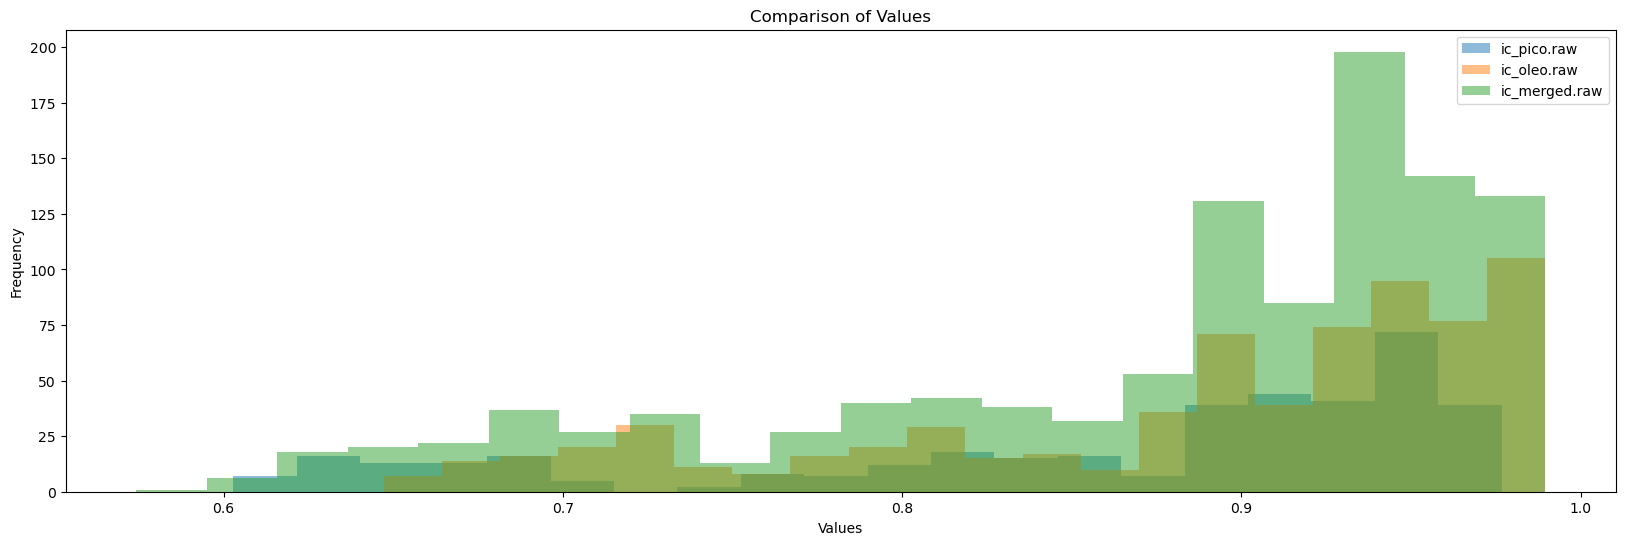

In [18]:
# we need to investigate why the merged assembly has a lower internal consistency
# first of all let's plot the internal consistency behavior for all the assemblies


pico_values = ic_pico.raw.values.flatten()
plt.figure(figsize=(20, 6))
plt.hist(pico_values, bins=20, alpha=0.5, label='ic_pico.raw')
oleo_values = ic_oleo.raw.values.flatten()
plt.hist(oleo_values, bins=20, alpha=0.5, label='ic_oleo.raw')
merged_values = ic_merged.raw.values.flatten()
plt.hist(merged_values, bins=20, alpha=0.5, label='ic_merged.raw')

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Comparison of Values')
plt.legend()
plt.show()


In [19]:
# Get unique neuroid_ids for each xarray
pico_neuroid_ids = ic_pico.raw.neuroid_id.values
oleo_neuroid_ids = ic_oleo.raw.neuroid_id.values
merged_neuroid_ids = ic_merged.raw.neuroid_id.values

per_neuron_ic_merged = {}
for id in merged_neuroid_ids:
    if id not in per_neuron_ic_merged:
        per_neuron_ic_merged[id] = []
    per_neuron_ic_merged[id].append(np.mean(ic_merged.raw.sel(neuroid_id=id).values))

per_neuron_ic_pico = {}
for id in pico_neuroid_ids:
    if id not in per_neuron_ic_pico:
        per_neuron_ic_pico[id] = []
    per_neuron_ic_pico[id].append(np.mean(ic_pico.raw.sel(neuroid_id=id).values))

per_neuron_ic_oleo = {}
for id in oleo_neuroid_ids:
    if id not in per_neuron_ic_oleo:
        per_neuron_ic_oleo[id] = []
    per_neuron_ic_oleo[id].append(np.mean(ic_oleo.raw.sel(neuroid_id=id).values))

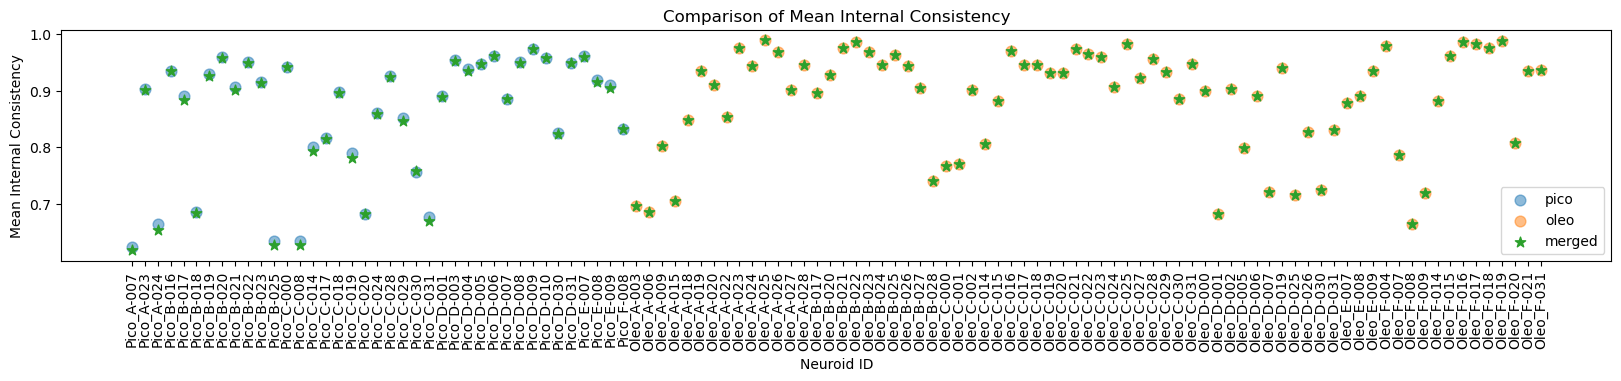

In [20]:
# Extracting x and y values for plotting from dictionaries
neuroid_ids_pico = list(per_neuron_ic_pico.keys())
ic_values_pico = [np.mean(per_neuron_ic_pico[id]) for id in neuroid_ids_pico]

neuroid_ids_oleo = list(per_neuron_ic_oleo.keys())
ic_values_oleo = [np.mean(per_neuron_ic_oleo[id]) for id in neuroid_ids_oleo]

neuroid_ids_merged = list(per_neuron_ic_merged.keys())
ic_values_merged = [np.mean(per_neuron_ic_merged[id]) for id in neuroid_ids_merged]


plt.figure(figsize=(20, 3))
plt.scatter(neuroid_ids_pico, ic_values_pico, label='pico', marker='o', s=60, alpha=0.5)
plt.scatter(neuroid_ids_oleo, ic_values_oleo, label='oleo', marker='o', s=60, alpha=0.5)
plt.scatter(neuroid_ids_merged, ic_values_merged, label='merged', marker='*', s=60, alpha=1)
plt.xlabel('Neuroid ID')
plt.ylabel('Mean Internal Consistency')
plt.title('Comparison of Mean Internal Consistency')
plt.xticks(rotation='vertical') 
plt.legend()
plt.show()
